<div align="center"> 

---

# **Inmunofluorescence metrics**

</div>


---

<div align="center"> 

![Inmuno.png](attachment:2)

</div>

---
# <u> **Description:**</u>

Inmunofluorescence metrics

---

## **Workflow**

1. General preparation
2. Data preparation
3. Analysis
4. Exploratory data analysis
5. Visualization
6. Export data

---

**Variables to consider:** 
  - Session
  - Sex  
  
**ROIs:**
  - Hippocampus (CA2)
  - Caudate-Putamen (CPu)
  
**Analysis:**
  - 
  - 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=14, repr.plot.height=10) # to resize plots

1 
1

In [2]:
setwd("/mnt/c/Users/jalil/phd/PhD/Psilantro/Sudmex_alcohol_stress/")

In [3]:
load("Data/Alcohol_consumption.RData")

In [4]:
load("Data/Behavior_metricsEPM.RData")

In [5]:
load("Data/Behavior_metricsNOR.RData")

In [6]:
load("Data/Behavior_metricsCPP.RData")

## **1. General preparation**

### **1.1 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [7]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,readxl,lme4,devtools,ggpubr,rstatix,ggdist,ggmap,data.table,cowplot,
    corrplot,magrittr,gghalves,skimr,emmeans,multcomp,easystats,scales,reshape2,RColorBrewer,caret,uwot,dbscan,umap)


Loading required package: pacman

Installing package into ‘/home/jalil/R’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppAnnoy’




In [8]:
pal_batch <- c("#264653","#2a9d8f","#5e548e","#ff595e","#03045e")

## **2. Data preparation**

Reading files and set it all up.

In [9]:
RID_group <- read_csv("Data/RID_group.csv")

Rows: 96 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): RID, Group, Sex, Batch

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [10]:
Morph_names <- list.files(paste0(getwd(),"/Data/Inmunofluorescence/Morphology/"), pattern = "CPu.*\\.csv$", full.names = FALSE) %>%
       map(~ .x %>% str_remove(".csv") %>% str_remove("Data/Inmunofluorescence/Morphology/"))

suppressMessages(invisible(capture.output(
Morph_files <- list.files(paste0(getwd(),"/Data/Inmunofluorescence/Morphology/"), pattern = "CPu.*\\.csv$", full.names = TRUE) %>%
       map(~ .x %>% read_tsv()) %>% set_names(Morph_names)
       )))

Morph_names_CA <- list.files(paste0(getwd(),"/Data/Inmunofluorescence/Morphology/"), pattern = "CA2.*\\.csv$", full.names = FALSE) %>%
       map(~ .x %>% str_remove(".csv") %>% str_remove("Data/Inmunofluorescence/Morphology/"))

suppressMessages(invisible(capture.output(
Morph_files_CA <- list.files(paste0(getwd(),"/Data/Inmunofluorescence/Morphology/"), pattern = "CA2.*\\.csv$", full.names = TRUE) %>%
       map(~ .x %>% read_tsv()) %>% set_names(Morph_names_CA)
       )))

In [11]:
Morph_metrics <- Morph_files %>% map(~ .x %>% 
        mutate(RID = if_else(as.numeric(str_split(Path_Annotations,pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R"))) <= 99,
                                        paste0("sub-0",str_split(Path_Annotations, pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R"))),
                                        paste0("sub-",str_split(Path_Annotations, pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R")))),.before = 1,
                Slice = str_split(Path_Annotations,pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(5) %>% str_remove("-annotations.tif")))) %>% 
        reduce(rbind) %>% left_join(RID_group, by = "RID") %>% 
        mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
            RID = factor(RID)) %>% drop_na()

Morph_metrics_CA <- Morph_files_CA %>% map(~ .x %>% 
        mutate(RID = if_else(as.numeric(str_split(Path_Annotations,pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R"))) <= 99,
                                        paste0("sub-0",str_split(Path_Annotations, pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R"))),
                                        paste0("sub-",str_split(Path_Annotations, pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(1) %>% str_remove("R")))),.before = 1,
                Slice = str_split(Path_Annotations,pattern = "_") %>% 
                                    map_chr(~ .x %>% extract(5) %>% str_remove("-annotations.tif")))) %>% 
        reduce(rbind) %>% left_join(RID_group, by = "RID") %>% 
        mutate(Group = factor(Group, levels = c("Ctrl", "Alc","Str","Alc+Str")),
            RID = factor(RID)) %>% drop_na()

In [12]:
Morph_vars <- Morph_metrics %>% select_if(is.numeric) %>% dplyr::select(-c(Object_Label)) %>% colnames()

## **3. Data analysis**

Morphological analysis based on [Microglia morphometry](https://doi.org/10.1098/rsob.220200)

In [13]:
#### Utility functions ####

# Compute new features and add them to the input data frame
compute_derived_features <- function(df) {
  df$Solidity <- df$Area_Pixel2 / df$ConvexArea_Pixel2
  df$Roundness <- df$Area_Pixel2 / df$EllipsoidLongestAxisRadius_Pixel^2
  df$Roundness2 <- df$Area_Pixel2 / df$EllipsoidShortestAxisRadius_Pixel^2
  df$GeodesicElongation <- df$GeodesicDiameter_Pixel^2 / df$Area_Pixel2 
  df$AspectRatio <- df$LargestInscribedCircleRadius_Pixel^2 / df$Area_Pixel2 
  df$Circularity <- df$Area_Pixel2 / df$Perimeter_Pixel^2
  df$Somaness <- df$RadiusAtBrightestPoint_Pixel^2 / df$Area_Pixel2 
  df$Branchiness <- df$SkeletonNumBranchPoints / df$GeodesicDiameter_Pixel
  df$Straightness <- df$SkeletonLongestBranchLength_Pixel^2 / df$Area_Pixel2
  df$Thickness <- df$Area_Pixel2 / df$SkeletonTotalLength_Pixel^2
  return(df)
}

# Data clean up:
# - Remove empty rows
# - Remove duplicated cells
# - Remove cells touching the image border
# - Remove cells not annotated with expected terms
clean_up <- function(df) {
  
  # Remove empty rows
  df <- df[df$Object_Label!="",]

  # Remove duplicated cells
  duplicates <- duplicated(df[,c("Centroid_Time_Frames", "BrightestPoint_X_Pixel", "BrightestPoint_Y_Pixel", "Path_Intensities")])
  if(any(duplicates)) {
    warning(paste0("Removing duplicates in ", paste(unique(df$Path_Intensities[duplicates]), collapse = ", "), "\n"))
    df <- df[!duplicates,]
  }
  
  # Remove cells that significantly touch the image border
  # A cell touches the border if the number of pixels on the border is more than 1% of its perimeter
  excluded.cells <- which(df$ImageBoundaryContact_Pixel>0.01*df$Perimeter_Pixel)
  if(length(excluded.cells)>0){
    df <- df[-excluded.cells,]
  }
  
  # Remove unexpected annotations
  # df$Morphology[is.na(df$Morphology)] <- 'Not annotated' # NA -> not annotated
  # idx <- which(!(df$Morphology %in% c(classes, 'Not annotated')))
  # if(length(idx)>0) { # Cells with unexpected terms are considered not annotated
  #   df$Morphology[idx] <- 'Not annotated'
  # }
  return(df)
}

In [14]:
# Where to write the results
output.dir = paste0(getwd(),"/Statistics/Inmunofluorescence/Morphology/")
dir.create(output.dir, recursive = TRUE)

# Names of the morphology classes of interest
classes <- c("Round", "Inflamed_Ameboid", "Fried_egg", "Inflamed_Fried_egg", "Hypertrophic", "Inflamed_Hypertrophic", "Bipolar")

# Names of the features we're going to work with
feat.to.keep <- c("Morphology", "Centroid_Time_Frames","Area_Pixel2", "BrightestPointToCentroidDistance_Pixel", "ConvexArea_Pixel2", "EllipsoidLongestAxisRadius_Pixel", "EllipsoidShortestAxisRadius_Pixel", "GeodesicDiameter_Pixel", "LargestInscribedCircleRadius_Pixel", "Perimeter_Pixel", "RadiusAtBrightestPoint_Pixel", "SkeletonAvgBranchLength_Pixel", "SkeletonLongestBranchLength_Pixel", "SkeletonTotalLength_Pixel", "SkeletonNumBranchPoints", "Solidity", "Roundness", "Roundness2", "GeodesicElongation", "AspectRatio", "Circularity", "Somaness", "Branchiness", "Straightness", "Thickness")
names_numeric <- c("GeodesicDiameter_Pixel","LargestInscribedCircleRadius_Pixel")
vars_interest <- c("Solidity", "Roundness", "Roundness2", "GeodesicElongation", "AspectRatio", "Circularity", "Somaness", "Branchiness", "Straightness", "Thickness")

In [15]:
Morph_metrics_cleaned <- clean_up(Morph_metrics) %>% 
    mutate_at(vars(names_numeric),~ ifelse(. == "Infinity", NA, .)) %>% 
    mutate_at(vars(names_numeric), as.numeric) %>% 
    drop_na()
Morph_metrics_features <- compute_derived_features(Morph_metrics_cleaned)

In [16]:
Morph_metrics_CA_cleaned <- clean_up(Morph_metrics_CA) %>% 
    mutate_at(vars(names_numeric),~ ifelse(. == "Infinity", NA, .)) %>% 
    mutate_at(vars(names_numeric), as.numeric) %>% 
    drop_na()
Morph_metrics_CA_features <- compute_derived_features(Morph_metrics_CA_cleaned)

In [17]:
Morph_metrics_interest <- Morph_metrics_features %>% 
    dplyr::select(c(RID,Slice,Object_Label,Group,Sex,Batch,vars_interest))

Morph_metrics_CA_interest <- Morph_metrics_CA_features %>% 
    dplyr::select(c(RID,Slice,Object_Label,Group,Sex,Batch,vars_interest))

### **3.1 Stats (Linear modelling)**

In [18]:
suppressMessages(invisible(capture.output(
CPu_Lmod <-  vars_interest %>% map(~ lm(eval(paste0(.x," ~ Group + Batch")), data = Morph_metrics_interest) ) %>% set_names(vars_interest)
    )))
CPu_Lmod_Residuals <- CPu_Lmod %>% map_dfc(~ .x %>% residuals())

suppressMessages(invisible(capture.output(
CPu_contrast_Lmod <- CPu_Lmod %>%
    map(~ contrast(emmeans(.x,~ Group), method = "pairwise", adjust = "fdr")) %>% set_names(vars_interest)
    )))

suppressMessages(invisible(capture.output(
CPu_eff_size_Lmod <- vars_interest %>%
    map(~ eff_size(CPu_contrast_Lmod[[.x]], sigma = sigma(CPu_Lmod[[.x]]),edf = df.residual(CPu_Lmod[[.x]]) ) ) %>% set_names(vars_interest) 
    )))


CPu_significant_names_Lmod <- CPu_contrast_Lmod %>% map(~ .x %>% as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() %>% 
    dplyr::select(contrast, estimate, SE, df, p.value, p.value.signif) %>% 
    mutate(across(c(estimate, SE, df, p.value), ~ round(., 3))) ) %>% compact(1) 
CPu_significant_names_Lmod

contrast,estimate,SE,df,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - Str,-0.138,0.033,863,0.000,****
Ctrl - (Alc+Str),-0.083,0.035,863,0.026,*
Alc - Str,-0.103,0.024,863,0.000,****
Str - (Alc+Str),0.056,0.023,863,0.026,*
contrast,estimate,SE,df,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - Str,-0.439,0.105,863,0,***
Ctrl - (Alc+Str),-0.403,0.110,863,0,***
Alc - Str,-0.352,0.076,863,0,****


In [19]:
suppressMessages(invisible(capture.output(
CA_Lmod <-  vars_interest[-6] %>% map(~ lm(eval(paste0(.x," ~ Group + Batch")), data = Morph_metrics_CA_interest) ) %>% 
    set_names(vars_interest[-6])
    )))
CA_Lmod_Residuals <- CA_Lmod %>% map_dfc(~ .x %>% residuals())

suppressMessages(invisible(capture.output(
CA_contrast_Lmod <- CA_Lmod %>%
    map(~ contrast(emmeans(.x,~ Group), method = "pairwise", adjust = "fdr")) %>% set_names(vars_interest[-6])
    )))

suppressMessages(invisible(capture.output(
CA_eff_size_Lmod <- vars_interest[-6] %>%
    map(~ eff_size(CA_contrast_Lmod[[.x]], sigma = sigma(CA_Lmod[[.x]]),edf = df.residual(CA_Lmod[[.x]]) ) ) %>% 
        set_names(vars_interest[-6]) 
    )))


CA_significant_names_Lmod <- CA_contrast_Lmod %>% map(~ .x %>% as_tibble() %>% 
    filter(p.value < 0.05) %>% 
    add_significance() %>% 
    dplyr::select(contrast, estimate, SE, df, p.value, p.value.signif) %>% 
    mutate(across(c(estimate, SE, df, p.value), ~ round(., 3))) ) %>% compact(1) 
CA_significant_names_Lmod

contrast,estimate,SE,df,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - (Alc+Str),0.03,0.011,877,0.044,*
contrast,estimate,SE,df,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl - Str,0.030,0.012,877,0.022,*
Ctrl - (Alc+Str),0.035,0.012,877,0.021,*
Alc - Str,0.024,0.010,877,0.022,*
Alc - (Alc+Str),0.029,0.011,877,0.021,*


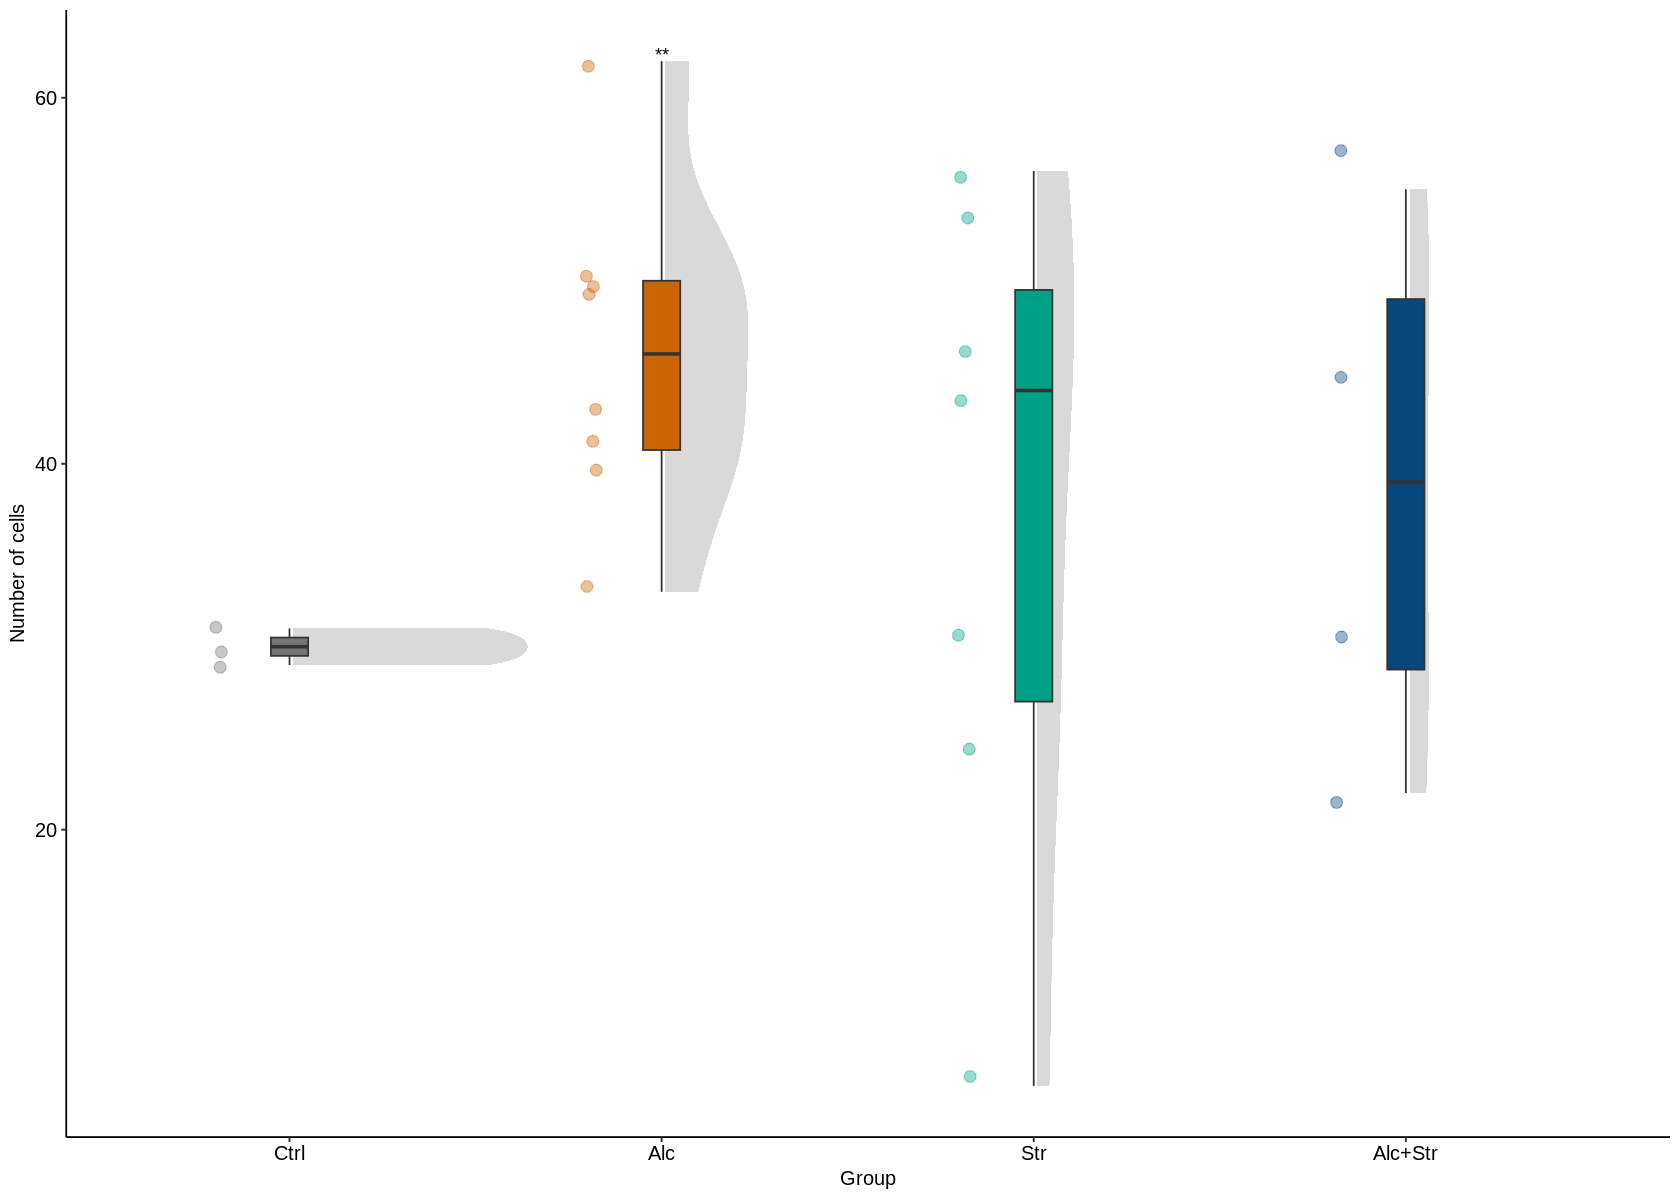

In [20]:
Morph_metrics_interest %>% group_by(RID,Slice,Group) %>% count() %>% 
    ggplot(aes(x = Group, y = n, fill = Group)) + 
    stat_halfeye(
        adjust = .8, width = .7, fill = "grey85",
        interval_colour = NA, 
        position = position_nudge(x = .01),
        aes(thickness = stat(f*n))) +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) +
    geom_half_point(side = "l", aes(color = Group, fill = Group),
                    range_scale = .1, alpha = .4, size = 3) +
    geom_boxplot(width = .1) +
    theme_pubr() +
    labs(x = "Group", y = "Number of cells") +
    theme(legend.position = "none")  +
    stat_compare_means(aes(label = after_stat(p.signif)), 
                    method = "t.test", ref.group = "Ctrl", hide.ns = TRUE)

### **3.2 Morphology classification**

In [21]:
Microglia_classes <- read_csv("Data/Inmunofluorescence/Morphologies_UMAP.csv")
metrics_umap <- read_table("Data/Inmunofluorescence/metrics4UMAP.txt")

Rows: 4861 Columns: 51
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): FrameInterval_Unit, VoxelSpacing_Unit, Path_LabelMasks, Path_Inten...
dbl (41): Object_Label, Centroid_Time_Frames, Area_Pixel2, BrightestPointToC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

── Column specification ────────────────────────────────────────────────────────
cols(
  x = col_character()
)



In [22]:
n.neighbours <- 15
n.components <- 2

# Find projection using annotated cells
u1 <- umap(Microglia_classes %>% dplyr::select(metrics_umap$x), y = Microglia_classes %>% dplyr::select(metrics_umap$x), 
    scale = TRUE, ret_model = TRUE, n_neighbors = n.neighbours, n_components = n.components)
    
# u <- umap(Morph_metrics_features[,-c(1:4)] %>% dplyr::select(metrics_umap$x), 
#     scale = TRUE, n_neighbors = n.neighbours, n_components = n.components)

In [23]:
Morph_metrics_features %>% write_csv("Data/Inmunofluorescence/Morph_metrics_CPu_features.csv")
Morph_metrics_CA_features %>% write_csv("Data/Inmunofluorescence/Morph_metrics_CA_features.csv")

In [24]:
u1$layout <- Microglia_classes %>% dplyr::select(UMAP.V1,UMAP.V2) %>% as.matrix()

In [25]:
# Project the whole data set in the new space
# u2 <- umap_transform(Morph_metrics_features[,-c(1:4)] %>% dplyr::select(metrics_umap$x), u1)

In [ ]:
Morph_metrics_features[,-c(1:4)] %>% dplyr::select(metrics_umap$x) %>% mutate(Morphology = "Not annotated")

## **4. Visualization**


In [27]:
#"plot all figures inside "Morph_boxplot_list" list
Morph_boxplot_list <- map(vars_interest, ~ ggplot(Morph_metrics_interest %>% 
      mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
                    Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+")), 
  aes(x = Group, y = .data[[.]], fill = Group)) + 
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = Group, fill = Group),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .1) +
  theme_pubr() +
  labs(x = "Group", y = .) +
  theme(legend.position = "none") +
  stat_compare_means(aes(label = after_stat(p.signif)), 
                  comparisons = list(c("EtOH-/CRS-", "EtOH+/CRS-"), c("EtOH-/CRS-", "EtOH-/CRS+"), c("EtOH-/CRS-", "EtOH+/CRS+"), 
                                      c("EtOH+/CRS-", "EtOH-/CRS+"), c("EtOH+/CRS-", "EtOH+/CRS+"), c("EtOH-/CRS+", "EtOH+/CRS+")),
                  hide.ns = TRUE, p.adjust.method = "fdr")
    ) %>% set_names(vars_interest)


In [28]:
#"plot all figures inside "Morph_boxplot_list" list
Morph_boxplot_CA_list <- map(vars_interest, ~ 
    ggplot(Morph_metrics_CA_interest %>% 
        mutate(Group = case_when(Group == "Ctrl" ~ "EtOH-/CRS-", Group == "Alc" ~ "EtOH+/CRS-", 
                    Group == "Str" ~ "EtOH-/CRS+",Group == "Alc+Str" ~ "EtOH+/CRS+")), 
                    aes(x = Group, y = .data[[.]], fill = Group)) + 
    stat_halfeye(
        adjust = .8, width = .7, fill = "grey85",
        interval_colour = NA, 
        position = position_nudge(x = .01),
        aes(thickness = stat(f*n))) +
    scale_color_manual(values = pal_group) +
    scale_fill_manual(values = pal_group) +
    geom_half_point(side = "l", aes(color = Group, fill = Group),
                    range_scale = .1, alpha = .4, size = 3) +
    geom_boxplot(width = .1) +
    theme_pubr() +
    labs(x = "Group", y = .) +
    theme(legend.position = "none") +
    stat_compare_means(aes(label = after_stat(p.signif)), 
                comparisons = list(c("EtOH-/CRS-", "EtOH+/CRS-"), c("EtOH-/CRS-", "EtOH-/CRS+"), c("EtOH-/CRS-", "EtOH+/CRS+"), 
                                    c("EtOH+/CRS-", "EtOH-/CRS+"), c("EtOH+/CRS-", "EtOH+/CRS+"), c("EtOH-/CRS+", "EtOH+/CRS+")),
                hide.ns = TRUE, p.adjust.method = "fdr")
    ) %>% set_names(vars_interest)

In [29]:
plot_morphology_metrics <- ggarrange(Morph_boxplot_list$Solidity,Morph_boxplot_list$Roundness,
                Morph_boxplot_list$GeodesicElongation,Morph_boxplot_list$AspectRatio,Morph_boxplot_list$Circularity,
                Morph_boxplot_list$Somaness,Morph_boxplot_list$Branchiness,Morph_boxplot_list$Straightness,
                Morph_boxplot_list$Thickness,
        ncol = 3, nrow = 3, common.legend = TRUE, legend = "top")

plot_morphology_CA_metrics <- ggarrange(Morph_boxplot_CA_list$Solidity,Morph_boxplot_CA_list$Roundness,
                Morph_boxplot_CA_list$GeodesicElongation,Morph_boxplot_CA_list$AspectRatio,Morph_boxplot_CA_list$Circularity,
                Morph_boxplot_CA_list$Somaness,Morph_boxplot_CA_list$Branchiness,Morph_boxplot_CA_list$Straightness,
                Morph_boxplot_CA_list$Thickness,
        ncol = 3, nrow = 3, common.legend = TRUE, legend = "top")

## **5. Export data**

In [30]:
dir.create("Figures/Inmuno/Morphology/", recursive = TRUE)

In [31]:
ggsave(plot = plot_morphology_metrics, dpi=300,height = 8, width = 11,bg="white",
       filename = "Figures/Inmuno/Morphology/plot_morphology_CPu_metrics.png")

ggsave(plot = plot_morphology_CA_metrics, dpi=300,height = 8, width = 11,bg="white",
       filename = "Figures/Inmuno/Morphology/plot_morphology_CA_metrics.png")